In [1]:
%load_ext autoreload
%autoreload 2
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_extras as pmx

# Introduction

INLA assumes some three-layer nested model of the form:

\begin{equation}
\theta \rightarrow x \rightarrow y
\end{equation}

Where the prior on the hyperparameters $\pi(\theta)$ is arbitrary, the prior on the latent field is Gaussian (and in precision form): $\pi(x) = N(\mu, Q^{-1})$ and the latent field is linked to the observables $y$ through some linear map.

In PyMC Extras, INLA works natively through `pmx.fit`. In particular, the current implementation requires as input the latent Gaussian RV `x` and its associated precision matrix `Q`. It uses a pytensor-native wrapper for SciPy `minimize` using the `pytensor.optimize` package to obtain the Laplace approximation:

\begin{equation}
\pi_G \sim N(\mu^*, \Sigma^*)
\end{equation}

Where $\mu^*(y, \theta)$ is the $x$ which maximimses $\textnormal{logp}(x \mid y, \theta)$, and $\Sigma^* = Q - f^"(x)\bigg\rvert_{x=\mu^*}$, where $f^"(x)$ is the Hessian of the measurement model $\textnormal{logp}(y \mid x, \theta)$.

### Current Limitations

As it stands, INLA in PyMC Extras has three main limitations:

- Does not support inference over the latent field, only the hyperparameters.
- Optimisation for $\mu^*$ is bottlenecked by calling `minimize`, and to a lesser extent, computing the hessian $f^"(x)$.
- Does not offer sparse support which can provide significant speedups.

## Example 1: AR-1 Autoregressive Model
In this example, we compare INLA to direct sampling using the AR-1 model, that is:

\begin{equation}
x_t = \rho x_{t-1} + \epsilon_t
\end{equation}
\begin{equation}
\epsilon_t \sim N(0, \sigma^2)
\end{equation}
\begin{equation}
\tau = \frac{1}{\sigma^2}
\end{equation}

With hyperparameters $\theta = (\rho, \tau)$, latent field $x$ and measurement model $y \sim \textnormal{Pois}(e^x)$. Note that due to the current bottlenecks in the `logp` for INLA, we can only run `T=10` datapoints tractably. Starting with direct sampling:

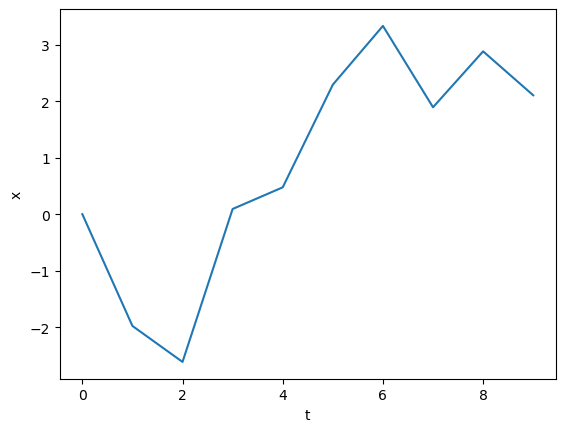

In [96]:
rng = np.random.default_rng(123)

T = 10
x = np.zeros((T,))

# true stationarity:
true_theta = 0.95
# true standard deviation of the innovation:
true_sigma = 2.0
# true process mean:
true_center = 0.0

for t in range(1, T):
    x[t] = true_theta * x[t - 1] + rng.normal(loc=true_center, scale=true_sigma)

y_obs = rng.poisson(np.exp(x))

plt.plot(np.arange(T), x)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [97]:
with pm.Model() as ar1:
    theta = pm.Normal("theta", 0.0, 1.0)
    tau = pm.Exponential("tau", 0.5)

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs)

    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, x]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


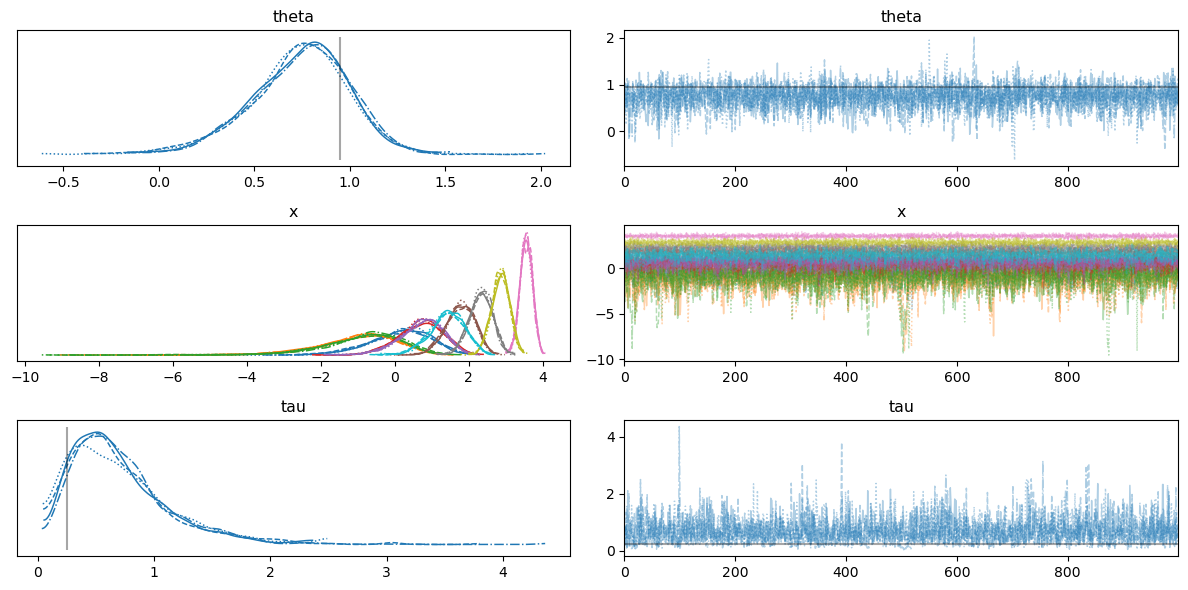

In [98]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma**-2),
    ],
)
plt.tight_layout()

It is easy to do the same in INLA - we only change the `pm.sample` line, leaving everything else the same.

In [94]:
with pm.Model() as ar1_inla:
    theta = pm.Normal("theta", 0, 1.0)
    tau = pm.Exponential("tau", 0.5)

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs)

    # Use INLA
    idata = pmx.fit(method="INLA", x=x, Q=tau, return_latent_posteriors=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


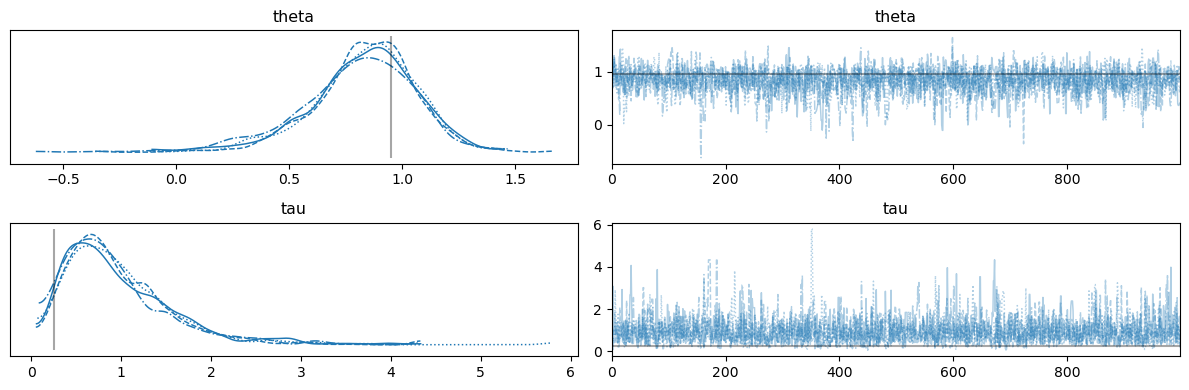

In [95]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma**-2),
    ],
)
plt.tight_layout()

Looking under the hood, we see that INLA works by marginalinazing out `x` and registering `y` as a custom `MarginalLaplaceRV`:

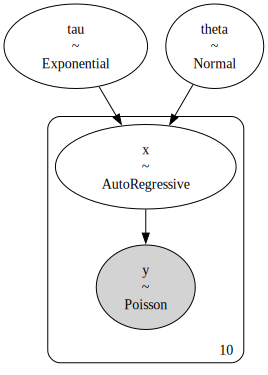

In [99]:
# Original Model
with pm.Model() as ar1_inla:
    theta = pm.Normal("theta", 0, 1.0)
    tau = pm.Exponential("tau", 0.5)

    x = pm.AR("x", rho=theta, tau=tau, steps=T - 1, init_dist=pm.Normal.dist(0, 100, shape=(T,)))

    y = pm.Poisson("y", mu=pm.math.exp(x), observed=y_obs_inla)

pm.model_to_graphviz(ar1_inla)

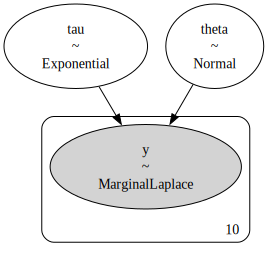

In [100]:
# Marginalized model used by INLA
from pymc_extras.model.marginal.marginal_model import marginalize

minimizer_kwargs = {"method": "L-BFGS-B", "optimizer_kwargs": {"tol": 1e-8}}
marginalize_kwargs = {
    "Q": ar1_inla.rvs_to_values[tau],
    "minimizer_seed": 42,
    "minimizer_kwargs": minimizer_kwargs,
}
marginal_model = marginalize(ar1_inla, x, use_laplace=True, **marginalize_kwargs)
pm.model_to_graphviz(marginal_model)